# 01 - Antivenom Parameter Regressions

*N.B. All references are detailed in the README.*

This code was used to predict the k<sub>10</sub>, k<sub>12</sub>, and k<sub>21</sub> pharmacokinetic rate constants for antivenom scaffolds of different molecular sizes.

k<sub>10</sub> represents the central compartment elimination rate, k<sub>12</sub> the transfer rate from the central to the peripheral compartment, and k<sub>21</sub> the transfer rate from the peripheral to the central compartment.

In this script, we:
   1. Predict the IgG k<sub>10</sub> by taking the geometric mean
   2. Regress the remaining k<sub>10</sub>, k<sub>12</sub>, and k<sub>21</sub> parameter values against molecular weight
   3. Plot the regressions (Fig. 3)
   4. Predict the k<sub>10</sub>, k<sub>12</sub>, and k<sub>21</sub> parameters for each scaffold

## 1. Predict IgG k<sub>10</sub>

Import packages and make 'graphs' output folder if it does not already exist.

In [17]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit 
from scipy.stats import gmean

if not os.path.exists('graphs'):
    os.makedirs('graphs')

Calculate IgG k<sub>10</sub>:

In [18]:
#Calculate geometric mean
IgGk10 = gmean([0.00875, 0.0148, 0.00916, 0.0139, 0.0282, 0.024, 0.00321])

print('IgG k10:', f'{IgGk10:.3}')

IgG k10: 0.012


## 2. Regress k<sub>10</sub>, k<sub>12</sub>, and k<sub>21</sub> against molecular weight

The following piece of code regresses the k<sub>10</sub>, k<sub>12</sub>, and k<sub>21</sub> datasets against molecular weight.


The remaining k<sub>10</sub> values are regressed against a sigmoidal equation (Defined by Li et al, 2017):

$\Large\ln(k_{10}) = 1 - \frac{c}{1 + e^{b(-MW+a)}} $

The k<sub>12</sub> values are regressed against a logarithmic equation:

$\Large\ln(k_{12}) = aln(MW) + b $

And the k<sub>21</sub> values are regressed against a linear equation:

$\Large\ln(k_{21}) = aMW + b $

MW = molecular weight (kDa)



First, initialise regression input data:

In [19]:
#Initialise k10 data ([MW, k10], [MW, k10]...)
K10_DATA = np.array([[6.5, 0.182],  [8, 0.174], [8, 0.150],  [16, 0.192], 
                    [50, 0.0182], [50, 0.23], [50, 0.0192], [50, 0.0264],  [50, 0.0169],  
                     [100, 0.0159], [100, 0.0124], [100, 0.0162], [100, 0.0528], [100, 0.066], [100, 0.0155], [100, 0.007], [100, 0.0376]])

#Initialise k12 data ([MW, k12], [MW, k12]...)
K12_DATA = np.array([[6.5, 0.7], [8, 0.6], [8, 0.8], [16, 0.6],
                     [50, 0.024], [50, 0.018],
                     [100, 0.204], [100, 0.504],
                     [150, 0.018], [150, 0.042] ])

#Initialise k21 data ([MW, k21], [MW, 21]...)
K21_DATA =  np.array([[6.5, 0.6], [8, 0.6], [8, 0.6], [16, 0.3],
                     [50, 0.036], [50, 0.09],  
                     [100, 0.21], [100, 0.426],  
                     [150,0.096], [150, 0.102] ])  

#Define x axis bounds of fitted regression predictions
PX = np.linspace(0.01, 160, 1000)

Define regression model equations in functions, and define a function to fit the regression (least squares):

In [20]:
#Define model equations as functions
def sigmoid(x, a, b, c):
    """ This function defines the sigmoid regression equation, where a, b, and c are unknown coefficients"""
    return 1 - (c / (1 + np.exp(b * (-x + a))))

def log(x, a, b):
    """ This function defines the logarithmic regression equation, where a and b are unknown coefficients"""
    return a*np.log(x) + b

def linear(x, a, b):
    """ This function defines the linear regression equation, where a and b are unknown coefficients"""
    return a*x + b

#Function to solve the regressions (init = initial parameter guess)
def fit_regression(dataset, function, init, parameter):
    """ This function fits a regression of a defined equation function using an input dataset.
    Parameters
    ----------
    dataset: array
        Input dataset, in the form [[x1, y1], [x2, y2], [x3, y3]...]] 
    function: function
        Name of regression equation function
    init: list
        List of initial guesses for the regression coefficients
    parameter: str
        Name of parameter being regressed
    Returns
    -------
    popt: array
        Calculated regression coefficients
    pcov: array
        Parameter covariance matrix
    ypred: array
        Array of predicted y data points using fitted regression equation
    """
    #Isolate the x and y input data
    xdata = (dataset[:,0])
    ydata = (dataset[:,1])
    #Transform y data to log scale
    ylndata=np.log(ydata)
    #Fit the curve. popt = optimal parameter/coefficient estimates, pcov = parameter covariance matrix
    popt, pcov = curve_fit(function, xdata, ylndata, init, method='dogbox')
    #Calculate the standard error of the coefficients
    variance = np.diagonal(pcov)
    SE = np.sqrt(abs(variance))
    #Print the parameter estimates and SE
    print('-----', parameter, 'Regression Coefficients', '-----', '\n',
          'Coefficients:', popt, '\n',
          'Standard error:', SE, '\n' )
    #Generate the predicted y values based on the fitted equation
    ypred = function(PX, *popt)
    return popt, pcov, ypred

Call the fitting functions and solve each regression:

In [21]:
#Call fitting function to solve each regression
k10reg = fit_regression(K10_DATA, sigmoid, [1, 1, 5], 'k10')
k12reg = fit_regression(K12_DATA, log, [1, 1], 'k12')
k21reg = fit_regression(K21_DATA, linear, [1, 1], 'k21')

#Unpack fitting function outputs to variable names
k10popt, k10pcov, k10ypred = k10reg
k12popt, k12pcov, k12ypred = k12reg
k21popt, k21pcov, k21ypred = k21reg

----- k10 Regression Coefficients ----- 
 Coefficients: [3.73973324 0.04525835 4.91723042] 
 Standard error: [8.79313429 0.0275138  0.39756357] 

----- k12 Regression Coefficients ----- 
 Coefficients: [-0.89400552  1.32472441] 
 Standard error: [0.33450234 1.26526373] 

----- k21 Regression Coefficients ----- 
 Coefficients: [-0.00884938 -0.98584559] 
 Standard error: [0.00526329 0.4416971 ] 



## 3. Plot the k<sub>10</sub>, k<sub>12</sub>, and k<sub>21</sub> regressions

First, define a function to plot the regressions:

In [22]:
def plot_regression(dataset, ypred, suptitle:str, ylabel:str, xlim:list, ylim:list, figlabel:str, ax=None):
    """
    This function plots the parameter regressions against the input data. It is called to individually plot each
    subplot.
    
    Parameters
    ----------
    dataset: array
        Input dataset, in the form [[x1, y1], [x2, y2], [x3, y3]...]] 
    ypred: array
        Regression prediction y data points
    suptitle: str
        Subtitle of plot
    ylabel: str
        y axis label
    xlim: list
        Lower and upper x axis limit
    ylim: list
        Lower and upper y axis limit
    figlabel: str
        Subplot panel label (ie a/b/c)
    ax: ax
        
    Returns
    -------
    Returns a plot of the regression, in position ax.
    
    """
    #Isolate the x and y input data
    xdata = (dataset[:,0])
    ydata = (dataset[:,1])
    #Transform y data to log scale
    ylndata=np.log(ydata)

    #Subplot the fitted regression
    ax = ax 
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_yscale('log')
    ax.set_xlabel('Molecular weight (kDa)', fontsize=8)
    ax.set_ylabel(ylabel, fontsize=8)
    ax.set_title(suptitle, fontsize=10, pad=0)
    #Plot the raw data
    ax.scatter(xdata, ydata, marker='o',facecolors='none', edgecolors='black')
    #Plot the regression line
    ax.plot(PX, np.exp(ypred), label='fit', color='black')
    #Plot the 2 fold error envelope
    ax.fill(np.append(PX, PX[::-1]), np.append((np.exp(ypred)*2), (np.exp(ypred)/2)[::-1]), 'gainsboro', zorder=0) 
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.text(-0.1, 1.2, figlabel, fontsize=10, transform=ax.transAxes,fontweight='bold', va='top', ha='right')
    return 

Set up plot area, and call plotting function to make the final graph:

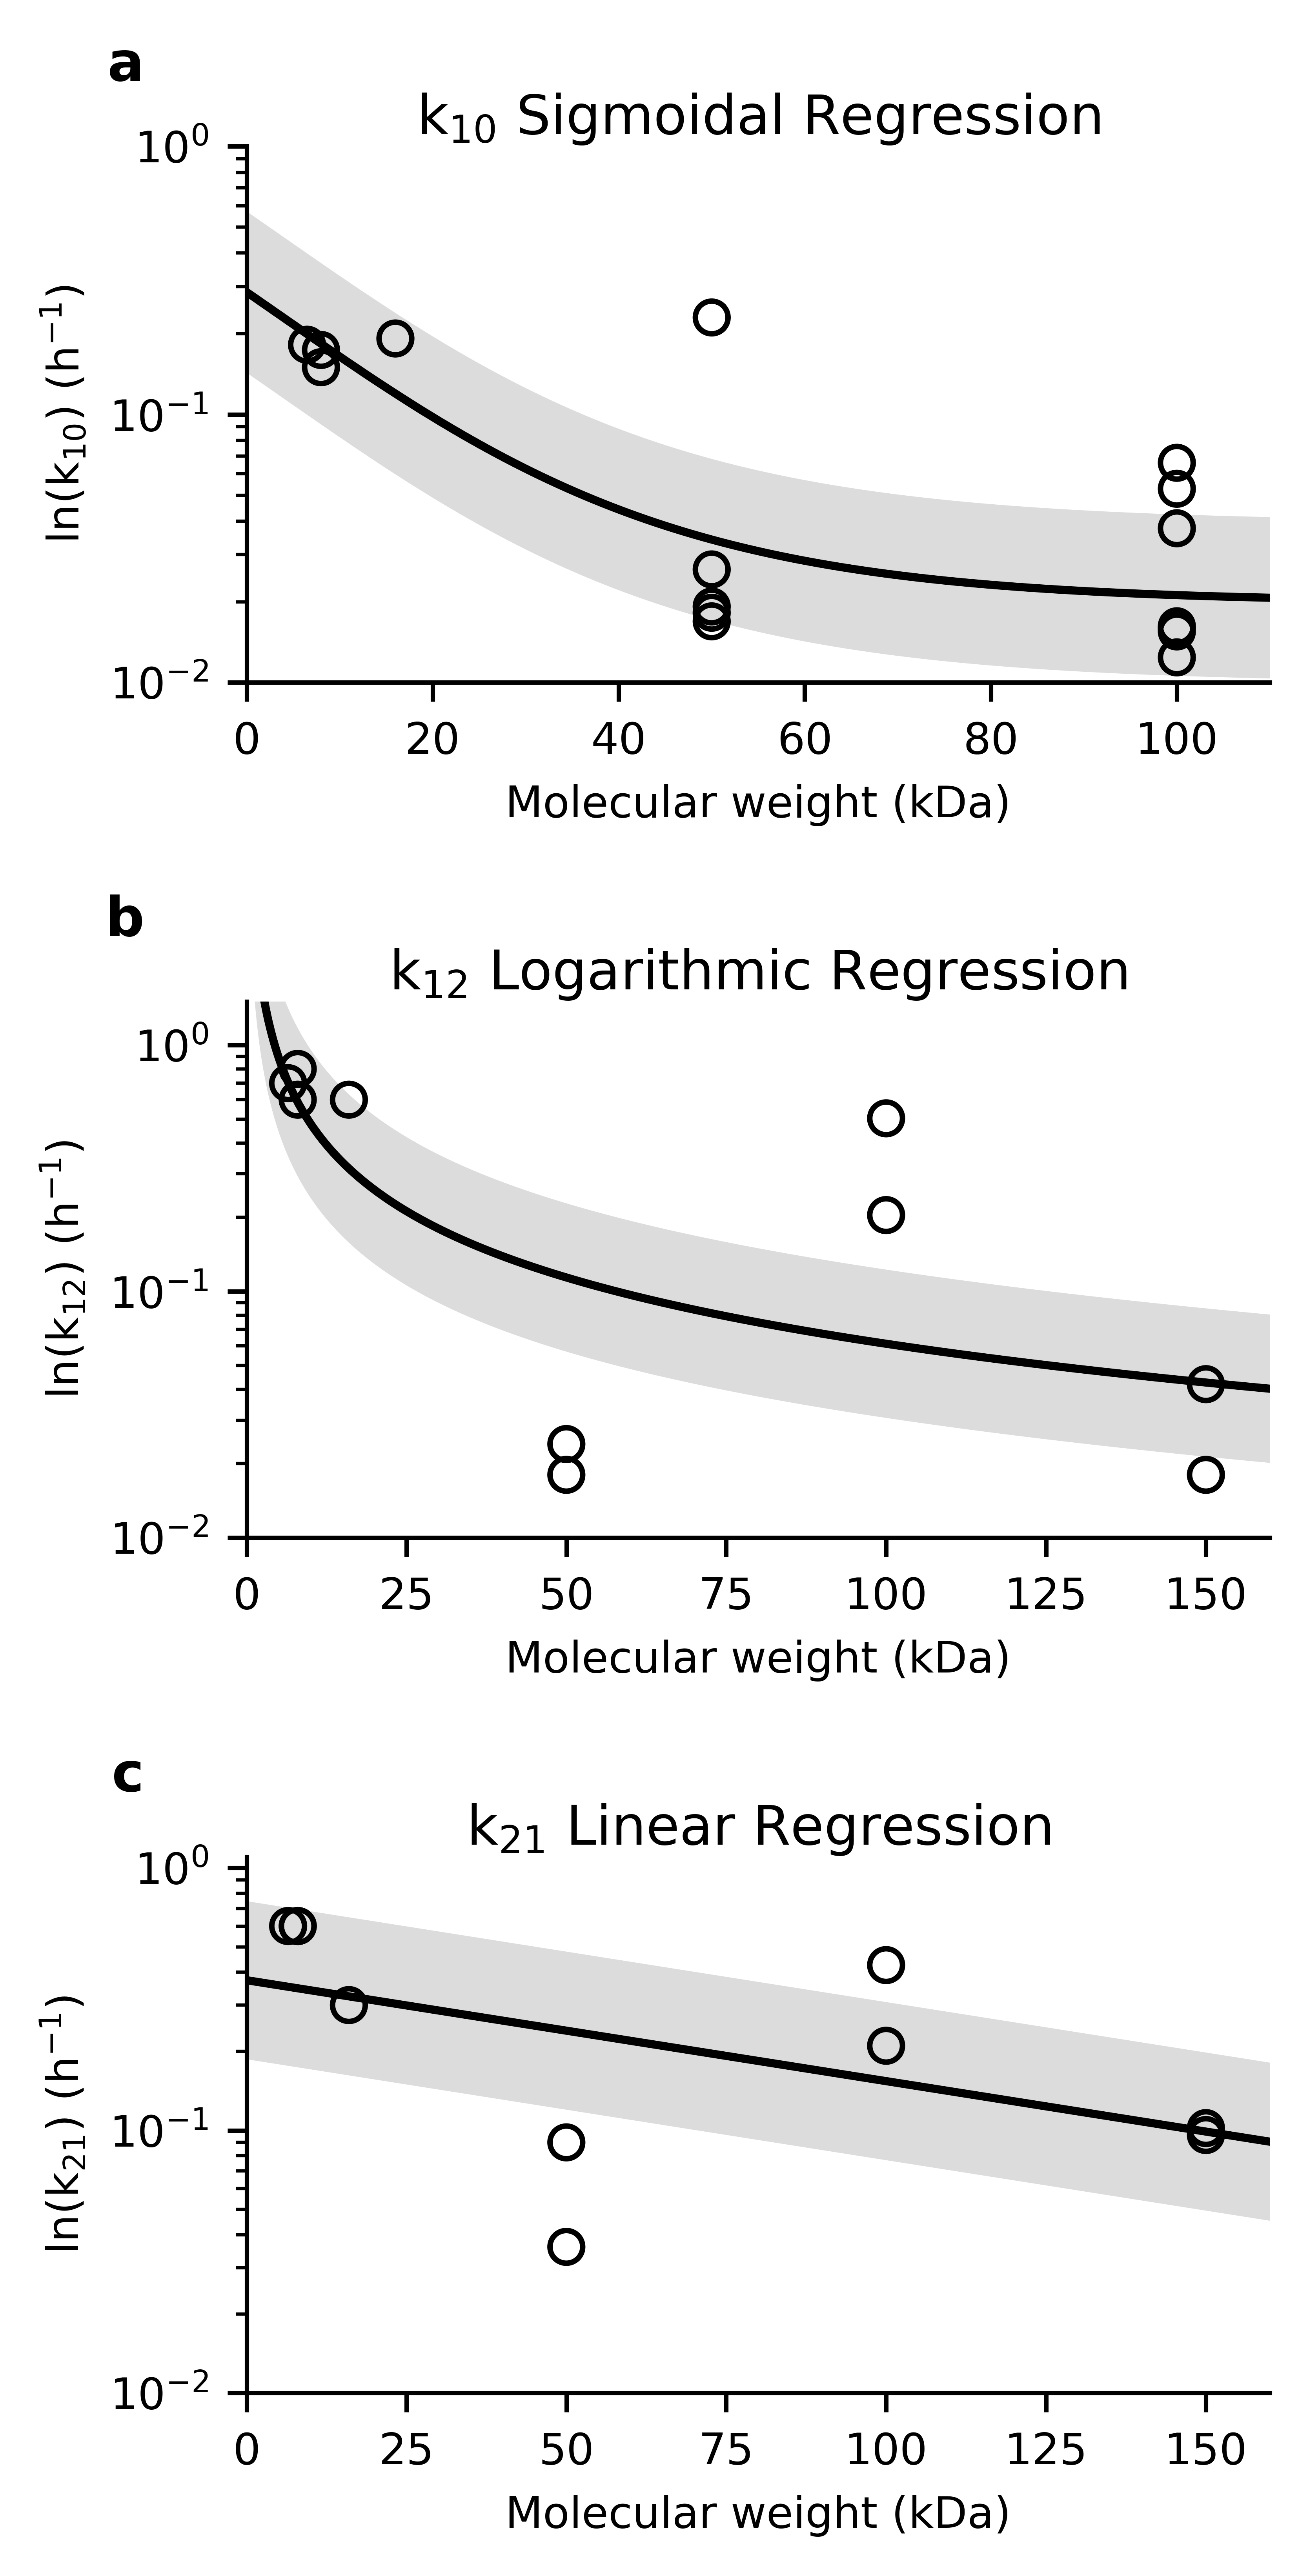

In [23]:
#Specify global plot parameters and settings
plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8)
cm = 1/2.54  # centimeters in inches
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(9*cm, 17*cm), dpi=1000)

#Plot regression
plot_regression(K10_DATA, k10ypred, 'k$_{10}$ Sigmoidal Regression', u'ln(k$_{10}$) (h$^{-1}$)', 
                [0, 110], [0.01, 1],  'a', ax1)
plot_regression(K12_DATA, k12ypred, 'k$_{12}$ Logarithmic Regression', u'ln(k$_{12}$) (h$^{-1}$)',  
                [0, 160], [10**-2, 1.5], 'b', ax2)
plot_regression(K21_DATA, k21ypred, 'k$_{21}$ Linear Regression', u'ln(k$_{21}$) (h$^{-1}$)', 
                [0, 160], [0.01, 1.1], 'c', ax3 )

plt.tight_layout()
#plt.savefig('graphs/Fig3.png', dpi=1000, bbox_inches='tight')
#plt.savefig('graphs/Fig3.eps', dpi=1000, bbox_inches='tight')
plt.show()

## 4. Predict k<sub>10</sub>, k<sub>12</sub>, and k<sub>21</sub> for five different antivenom scaffolds

Predict the parameters of five scaffolds using the fitted regression models:

* IgG (150kDa)
* F(ab')<sub>2</sub> fragment (100kDa)
* Fab fragment (50kDa)
* scFv (27kDa)
* Nanobody (15kDa)

**All predictions are given in h<sup>-1</sup>**

First, define the parameter prediction function:

In [26]:
def predictparams(scaffold, MW):
    """
    This function takes the scaffold molecular weight and applies it to the three regression equations (sigmoid, logarithmic, linear), 
    to generate a final k10/k12/k21 predicted parameter set. 
    
    Parameters
    ----------
    scaffold: str
        Name of scaffold
    MW: int
        Molecular weight of scaffold (kDa)

    Returns
    -------
    k10, k12, k12: tuple
        Predicted k10, k12, and k21 of scaffold  
    """
    
    #bypass the k10 param prediction for IgG (see section 1)
    if scaffold == 'IgG':
        k10 = IgGk10
    #calculate k10 parameter for all other scaffolds
    else:
        lnk10 = 1 - (k10popt[2] / (1 + np.exp(k10popt[1] * (-MW + k10popt[0]))))
        k10=np.exp(lnk10)
    #predict k12 parameters
    lnk12 = k12popt[0]*np.log(MW) + k12popt[1]
    k12=np.exp(lnk12)
    #predict k21 parameters
    lnk21 = k21popt[0]*MW + k21popt[1]
    k21=np.exp(lnk21)
    #print output
    print('-----', scaffold, 'parameter predictions', '-----')
    print('k10:', f'{k10:.3}', '\n',
          'k12:', f'{k12:.3}', '\n',
          'k21:', f'{k21:.3}', '\n')
    return k10, k12, k21

Call the function to output the predicted parameters:

In [27]:
predictparams('IgG', 150)
predictparams('Fab2', 100)
predictparams('Fab', 50)
predictparams('scFv', 27)
predictparams('Nanobody', 15)

----- IgG parameter predictions -----
k10: 0.012 
 k12: 0.0426 
 k21: 0.0989 

----- Fab2 parameter predictions -----
k10: 0.0212 
 k12: 0.0613 
 k21: 0.154 

----- Fab parameter predictions -----
k10: 0.0341 
 k12: 0.114 
 k21: 0.24 

----- scFv parameter predictions -----
k10: 0.071 
 k12: 0.198 
 k21: 0.294 

----- Nanobody parameter predictions -----
k10: 0.126 
 k12: 0.334 
 k21: 0.327 



(0.12594869065615286, 0.33410918911185555, 0.32674138787972207)